
Question 1
Implement a program, that, computes a moving average of a sequence $x_t$, given as a list of numbers as a list. All the boundry values should be assumed to be zero.
$$
\mu_t = \frac{1}{L}\sum_{i=0}^{L-1} x_{t-i}
$$
Example:
For the list $[1,4,5,-1]$, moving average with window $L=3$ should output $[0.3333, 1.6666, 3.3333, 2.6666]$.
Then your program must plot the original sequence and the moving average. The plot should be as beautiful as possible. Demonstrate your program with a generated random walk of length $L=200$.


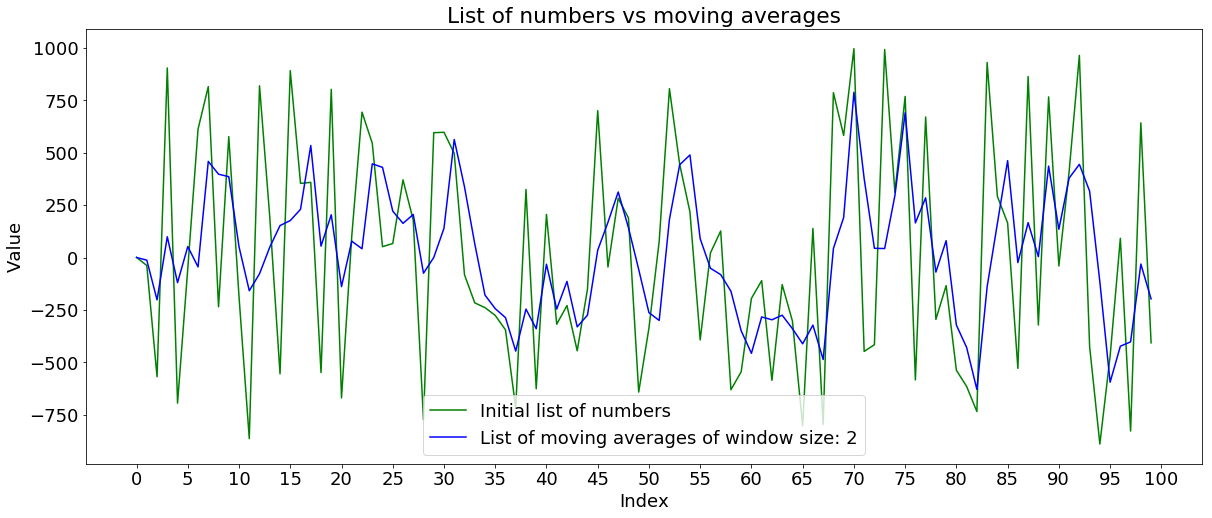

In [146]:
import numpy as np
import matplotlib.pyplot as plt

def getMovingAverage(listOfNumbers,window):
    ##get the cumulative sum of the list
    cumulativeSums = np.cumsum(listOfNumbers)
    
    ##insert list of zeros at the beginning of the list,drop last #window values
    zeros = np.zeros(window)
    modifiedList = np.insert(cumulativeSums[:-window],0,zeros)

    ##if you substract modifiedList from cumulativeSums element by element, you map each element to sum of last #window elements starting from the element
    ##then divide by window to get the average
    movingAverageList = (cumulativeSums - modifiedList) / window
    
    return movingAverageList

def getPlot(originalList,movingAverageList,window):
    originalPlot = plt.plot(originalList,'g',label='Initial list of numbers')
    movingAveragePlot = plt.plot(movingAverageList,'b',label='List of moving averages of window size: '+str(window))
    
    plt.title("List of numbers vs moving averages")
    plt.xlabel("Index")
    dim=np.arange(0,len(originalList)+5,5)
    plt.xticks(dim)
    plt.ylabel("Value")
    plt.legend(loc='best')
    plt.gcf().set_size_inches(20,8)
    plt.rcParams.update({'font.size': 18})
    plt.show()
    
numbers=np.random.randint(-1000,1000,100)
getPlot(numbers,getMovingAverage(numbers,3),2)

    
    

Question 2:
Implement the Binomial options pricing model for pricing European, American and Bermudan call and put options - you can find a reference implementation on 0Wikipedia

Implementation of American&Bermudan&European option price calculations

In [313]:
"""
Calculation of Bermudan options is added on top of a calculation for Europen&American options found on the internet
"""

import math
import numpy as np

class Option(object):
    ##General object constructor for all options
    def __init__(self, S0, K, r, T, N, params):
        self.S0 = S0
        self.K = K # Exercise price
        self.r = r # Interest rate
        self.T = T # Time to expiration in years
        self.N = max(1, N) # Ensure N have at least 1 time step
        self.STs = None # Declare the stock prices tree

        self.pu = params.get("pu", 0) # Probability of up state
        self.pd = params.get("pd", 0) # Probability of down state

        self.div = params.get("div", 0) # Dividend yield
        self.sigma = params.get("sigma", 0) # Volatility
        self.is_call = params.get("is_call", True) # Call or put
        
        
        ##Definde the type of option
        self.is_european = params.get("is_eu", False)
        self.is_american = params.get("is_am", False)
        self.is_bermudan = params.get("is_ber", False)
        
        ##Nodes respresenting exercise dates of a Bermudan option
        self.bermudan_dates = params.get("be_date",0)

        
        self.dt = T/float(N) # Single time step, in years
        self.df = math.exp(-(r-self.div) * self.dt) # Discount factor
        
class BinomialTreeOption(Option):
    def _setup_parameters_(self):
        self.u = 1 + self.pu # Expected value in the up state
        self.d = 1 - self.pd # Expected value in the down state
        self.qu = (math.exp((self.r-self.div)*self.dt) - self.d)/(self.u-self.d)
        self.qd = 1-self.qu
        
    def _initialize_stock_price_tree_(self):
        # Initialize a 2D tree at T=0
        self.STs = [np.array([self.S0])]
        # Simulate the possible stock prices path
        for i in range(self.N):
            prev_branches = self.STs[-1]
            st = np.concatenate((prev_branches*self.u,[prev_branches[-1]*self.d]))
            self.STs.append(st) # Add nodes at each time step
            
    def _initialize_payoffs_tree_(self):
        # The payoffs when option expires
        return np.maximum(0, (self.STs[self.N]-self.K) if self.is_call else (self.K-self.STs[self.N]))
    
    def __check_early_exercise__(self, payoffs, node):
        early_ex_payoff = (self.STs[node] - self.K) if self.is_call else (self.K - self.STs[node])
        return np.maximum(payoffs, early_ex_payoff)
    
    """
    The most crucial change is made in the method below to adapt Bermudan options
    """
    def _traverse_tree_(self, payoffs):
        for i in reversed(range(self.N)):
            # The payoffs from NOT exercising the option
            payoffs = (payoffs[:-1] * self.qu + payoffs[1:] * self.qd) * self.df
            
            # Payoffs from exercising, for American options
            if self.is_american:
                payoffs = self.__check_early_exercise__(payoffs,i)
            
            # Payoffs from exercising for Bermudan options on specified dates as node numbers
            if self.is_bermudan:
                if i in self.bermudan_dates:
                    payoffs = self.__check_early_exercise__(payoffs,i)
        return payoffs
    
    def __begin_tree_traversal__(self):
        payoffs = self._initialize_payoffs_tree_()
        return self._traverse_tree_(payoffs)
    
    def price(self):
        self._setup_parameters_()
        self._initialize_stock_price_tree_()
        payoffs = self.__begin_tree_traversal__()
        return payoffs[0]

bermudanOption = BinomialTreeOption(80, 30, 0.035, 0.75, 20,{"pu": 0.2, "pd": 0.2, "is_call": True,"is_eu": True,"be_date":[1,2,3,4,5]})
optionPrice = bermudanOption.price() 
print("Option price is "+str(optionPrice))

Option price is 53.5995147766


Question 3
Read the following price data and implement a back testing program to evaluate the return for the following investment strategy:
Initially invest $p$ and $1-p$ percent of a total kapital $K$ to each stock respectively (microsoft and apple).
Every weekend, only using past averages of last two weeks, evaluate the following:
If both stocks lost in value, or both stocks gain in value, do nothing
Otherwise sell $r$ percent of the loosing stock with the opening price and invest the money immediately in the winning stock.
Plot the evolution of the capital and compare with the return of the static strategy where you rebalance every week to keep the $p$ - $1-p$ portfolio. Ignore any transaction fees.

Last part with graphs are missing

2017-01-09 00:00:00
sell microsoft
2017-02-06 00:00:00
sell microsoft
2017-03-06 00:00:00
sell microsoft
2017-05-15 00:00:00
sell microsoft
2017-05-22 00:00:00
sell microsoft
2017-07-10 00:00:00
sell apple
2017-08-07 00:00:00
sell microsoft
2017-09-11 00:00:00
sell apple
2017-09-18 00:00:00
sell apple
2017-10-23 00:00:00
sell apple
2017-11-13 00:00:00
sell microsoft


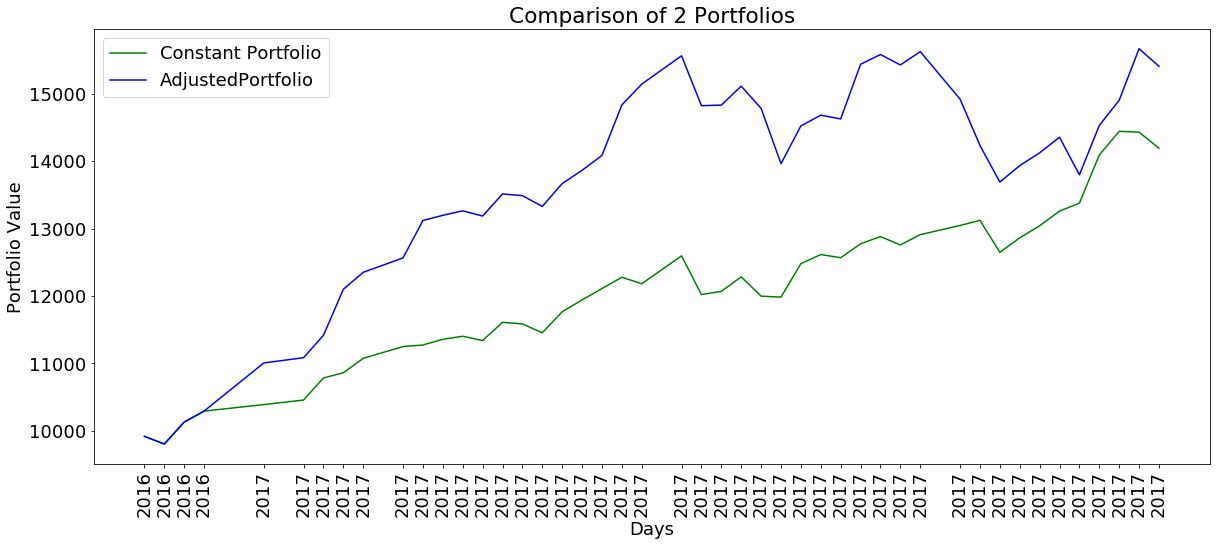

In [139]:
import pandas as pd
from pandas_datareader import data as web
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime,timedelta

start = datetime(2016,1,1)
end = datetime(2017,1,1)

msft = web.DataReader("MSFT", 'google', start, end)
aapl = web.DataReader("AAPL",'google',start,end)

priceData = pd.DataFrame({"APPLE":aapl.Open, "MICROSOFT":msft.Open},index=aapl.index)

class Account:
    def __init__(self, appleQuantity, msoftQuantity,initialCash):
        self.Position = {'Cash': initialCash,'Apple': appleQuantity, 'Microsoft': msoftQuantity} 
    def getPortfolio(self):
        return self.Position
    def reposition (self,r,winnerName,winnerStockPrice,loserName,loserStockPrice):
        soldQuantity = self.Position[loserName]*r
        soldAmount = soldQuantity*loserStockPrice
        boughtQuantity = soldAmount/winnerStockPrice
        self.Position[winnerName]+=boughtQuantity
        self.Position[loserName]-=soldQuantity
    
def BackTester(df,account,p,r):
    
    balancedPortfolioHistory = pd.DataFrame({'Apple':[],'Microsoft':[]})
    nonBalancedPortfolioHistory = pd.DataFrame({'Apple':[],'Microsoft':[]})
    
    initialApplePrice=df.APPLE.iloc[0]
    initialMicrosoftPrice=df.MICROSOFT.iloc[0]
    portfolio = account.getPortfolio()
    
    initialAppleQuantity=(portfolio['Cash']*p)/initialApplePrice
    initialMicrosoftQuantity=(portfolio['Cash']*(1-p))/initialMicrosoftPrice
    
    account.__init__(initialAppleQuantity,initialMicrosoftQuantity,0)
    
    for i in df.iterrows():
        if (i[0].weekday()==0): #check whether it's the start of week
            nonBalancedPortfolioHistory.loc[i[0]] = [i[1].APPLE*initialAppleQuantity,i[1].MICROSOFT*initialMicrosoftQuantity]
            
            #get last 2 weeks' prices
            applePriceTwoWeeks=df[(df.index>(i[0]-timedelta(days=14)))&(i[0]>df.index)].APPLE 
            microsoftPriceTwoWeeks=df[(df.index>(i[0]-timedelta(days=14)))&(i[0]>df.index)].MICROSOFT
            
            #get profit loss for two stocks
            plApple = i[1].APPLE - applePriceTwoWeeks.mean()
            plMicrosoft = i[1].MICROSOFT - microsoftPriceTwoWeeks.mean()
            
            if(plApple*plMicrosoft<0):
                print(i[0])
                if(plApple<plMicrosoft):
                    account.reposition(r,'Microsoft',i[1].MICROSOFT,'Apple',i[1].APPLE)
                    print('sell apple')
                else:
                    account.reposition(r,'Apple',i[1].APPLE,'Microsoft',i[1].MICROSOFT)
                    print('sell microsoft')
            newPortfolio = account.getPortfolio()
            balancedPortfolioHistory.loc[i[0]] = [i[1].APPLE*newPortfolio['Apple'],i[1].MICROSOFT*newPortfolio['Microsoft']]
    nonBalancedPortfolioHistory['Total'] = nonBalancedPortfolioHistory.Apple+nonBalancedPortfolioHistory.Microsoft
    balancedPortfolioHistory['Total'] = balancedPortfolioHistory.Apple+nonBalancedPortfolioHistory.Microsoft
    getPlot(nonBalancedPortfolioHistory,balancedPortfolioHistory)

def getPlot(constantPortfolio,balancedPortfolio):
    constantPlot = plt.plot(constantPortfolio.Total,'g',label='Constant Portfolio')
    balancedPlot = plt.plot(balancedPortfolio.Total,'b',label='AdjustedPortfolio')
    
    plt.title("Comparison of 2 Portfolios")
    plt.xlabel("Days")
    plt.xticks(constantPortfolio.index)
    plt.xticks(rotation=90)
    plt.ylabel("Portfolio Value")
    plt.legend(loc='best')
    plt.gcf().set_size_inches(20,8)
    plt.rcParams.update({'font.size': 18})
    plt.show()
        
account = Account(appleQuantity=0,msoftQuantity=0,initialCash=10000)
r = 0.1
p = 0.4
BackTester(priceData,account,p, r)


